# Deep Learning Fall 2023 Course Project - Zooming in on MLPs

### Imports

In [1]:
import os
import torch
import timm
import detectors

from PIL import Image
from tqdm import tqdm
from torchvision import transforms
from ffcv.fields import BytesField, IntField, RGBImageField
from ffcv.writer import DatasetWriter
from transformers import AutoImageProcessor, AutoModelForImageClassification, ViTFeatureExtractor, ViTForImageClassification

from data_utils.data_stats import *
from data_utils.dataloader import get_loader
from data_utils.dataset_to_beton import get_dataset
from models.networks import get_model
from utils.metrics import topk_acc, real_acc, AverageMeter

### Fetching data loader and model architecture

In [2]:
def get_data_and_model(dataset, model, data_path='/scratch/ffcv/'):
    """
    This function retrieves the data, model and feature extractor (if needed) based on the provided information.

    Parameters:
    dataset (str): The name of the dataset to retrieve (can be cifar10, cifar100 or imagenet).
    model (str): The name of the model to retrieve (can be mlp, cnn or vit; only mlp is supported for dataset imagenet).
    data_path (str): The path to the data.

    Returns (as a tuple):
    data_loader (DataLoader): The retrieved data loader.
    model (Model): The retrieved model.

    Raises:
    AssertionError: If the dataset or model is not supported.
    """

    assert dataset in ('cifar10', 'cifar100', 'imagenet'), f'dataset {dataset} is currently not supported by this function'
    assert model in ('mlp', 'cnn', 'vit'), f'model {model} is currently not supported by this function'

    num_classes = CLASS_DICT[dataset]
    eval_batch_size = 1024

    if dataset == 'imagenet':
        data_resolution = 64
        assert model == 'mlp', f'imagenet dataset is only supported by mlp model'
    else:
        data_resolution = 32

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    if device == 'cuda':
        torch.backends.cuda.matmul.allow_tf32 = True

    if model == 'mlp':
        crop_resolution = 64
        architecture = 'B_12-Wi_1024'
        checkpoint = 'in21k_' + dataset

        model = get_model(architecture=architecture, resolution=crop_resolution, num_classes=num_classes, checkpoint=checkpoint)

    if model == 'cnn':
        crop_resolution = 32
        architecture = 'resnet18_' + dataset

        model = timm.create_model(architecture, pretrained=True)

    if model == 'vit':
        crop_resolution = 32

        if dataset == 'cifar10':
            architecture = 'vit_small_patch16_224_cifar10_v4.pth'
            model = torch.load(architecture)

        elif dataset == 'cifar100':
            architecture = 'vit_small_patch16_224_cifar100_v3.pth'
            model = torch.load(architecture)

    data_loader = get_loader(
        dataset,
        bs=eval_batch_size,
        mode="test",
        augment=False,
        dev=device,
        mixup=0.0,
        data_path=data_path,
        data_resolution=data_resolution,
        crop_resolution=crop_resolution,
    )

    return data_loader, model

### Evaluating baseline model accuracy

In [3]:
# Define a test function that evaluates test accuracy
@torch.no_grad()
def test(model, loader, is_mlp = False):
    model.eval()
    total_acc, total_top5 = AverageMeter(), AverageMeter()

    for ims, targs in tqdm(loader, desc="Evaluation"):
        if is_mlp:
            ims = torch.reshape(ims, (ims.shape[0], -1))
        
        preds = model(ims)    
        acc, top5 = topk_acc(preds, targs, k=5, avg=True)
        
        total_acc.update(acc, ims.shape[0])
        total_top5.update(top5, ims.shape[0])

    return (
        total_acc.get_avg(percentage=True),
        total_top5.get_avg(percentage=True),
    )

In [5]:
data_loader, model = get_data_and_model(dataset='cifar10', model='mlp', data_path='/scratch/ffcv/')
test_acc, test_top5 = test(model, data_loader, True)

# Print all the stats
print("Test Accuracy        ", "{:.4f}".format(test_acc))
print("Top 5 Test Accuracy          ", "{:.4f}".format(test_top5))

Weights already downloaded
Load_state output <All keys matched successfully>
Loading /scratch/ffcv/cifar10/val_32.beton


Evaluation: 100%|██████████| 10/10 [01:06<00:00,  6.65s/it]

Test Accuracy         94.3900
Top 5 Test Accuracy           99.6600


### Evaluate adversarial accuracy

In [24]:
def denormalize(tensor, mean, std):
    """
    Denormalize a tensor.

    Parameters:
    tensor (torch.Tensor): The tensor to denormalize.
    mean (float or sequence): The mean used for normalization.
    std (float or sequence): The standard deviation used for normalization.

    Returns:
    torch.Tensor: The denormalized tensor.
    """
    return tensor*std[1]+mean[1]

def normalize(tensor, mean, std):
    """
    Normalize a tensor.

    Parameters:
    tensor (torch.Tensor): The tensor to normalize.
    mean (float or sequence): The mean used for normalization.
    std (float or sequence): The standard deviation used for normalization.

    Returns:
    torch.Tensor: The normalized tensor.
    """
    return (tensor-mean[1])/std[1]

def pgd(model, dataset, x_batch, label, eps, k, eps_step):
    """
    Performs the Projected Gradient Descent (PGD) for adversarial attacks.

    Parameters:
    model (torch.nn.Module): The model to attack.
    dataset (str): The name of the dataset used (can be cifar10, cifar100 or imagenet).
    x_batch (torch.Tensor): The input tensor.
    label (torch.Tensor): The true labels for the input tensor.
    eps (float): The maximum perturbation for PGD.
    k (int): The number of steps for PGD.
    eps_step (float): The step size for each iteration.

    Returns:
    torch.Tensor: The adversarially perturbed input tensor.
    """   
    mean, std = MEAN_DICT[dataset]/255, STD_DICT[dataset]/255

    x = x_batch.clone().detach_()
    x = denormalize(x, mean, std)
    x_adv = x + eps * (2*torch.rand_like(x) - 1)
    x_adv.clamp_(min=0., max=1.)
    
    for _ in range(int(k)):
        x_adv = normalize(x_adv, mean, std).detach_()
        x_adv.requires_grad_()
        model.zero_grad()
        loss = torch.nn.CrossEntropyLoss()(model(x_adv), label)
        loss.backward()
        perturbation = eps_step * x_adv.grad.sign()

        x_adv = denormalize(x_adv, mean, std)
        x_adv = x + (x_adv + perturbation - x).clamp_(min=-eps, max=eps)
        x_adv.clamp_(min=0, max=1)

    return normalize(x_adv.detach(), mean, std)

def fgsm_untargeted(model, dataset, x_batch, label, eps):
    """
    Performs the Fast Gradient Sign Method (FGSM) for untargeted adversarial attacks.

    Parameters:
    model (torch.nn.Module): The model to attack.
    dataset (str): The name of the dataset used (can be cifar10, cifar100 or imagenet).
    x_batch (torch.Tensor): The input tensor.
    label (torch.Tensor): The true labels for the input tensor.
    eps (float): The step size for the FGSM attack.

    Returns:
    torch.Tensor: The adversarially perturbed input tensor.
    """
    mean, std = MEAN_DICT[dataset]/255, STD_DICT[dataset]/255

    x = x_batch.clone().detach_()
    x.requires_grad_()
    model.zero_grad()
    loss = torch.nn.CrossEntropyLoss()(model(x), label)
    loss.backward()
    perturbation = eps * x.grad.sign()

    out = denormalize(x, mean, std) + perturbation
    out = out.clamp_(min=0, max=1)
        
    return normalize(out, mean, std)

In [25]:
def test_adversarial(model, dataset, loader, eps, mode, is_mlp = False):
    model.eval()
    total_adv_acc, total_adv_top5 = AverageMeter(), AverageMeter()

    for ims, targs in tqdm(loader, desc="Evaluation"):
        if is_mlp:
            ims = torch.reshape(ims, (ims.shape[0], -1))
        targs = targs
        if mode =="fgsm":
            adv_ims = fgsm_untargeted(model, dataset, ims, targs, eps)
        if mode == "pgd":
            adv_ims = pgd(model, dataset, ims, targs, eps=eps, k=5, eps_step=eps/2)

        adv_preds = model(adv_ims)
   
        adv_acc, adv_top5 = topk_acc(adv_preds, targs, k=5, avg=True)

        total_adv_acc.update(adv_acc, ims.shape[0])
        total_adv_top5.update(adv_top5, ims.shape[0])

    return (
        total_adv_acc.get_avg(percentage=True),
        total_adv_top5.get_avg(percentage=True),
    )

In [17]:
adv_acc = []
adv_top5 = []

data_loader, model = get_data_and_model(dataset='cifar10', model='mlp', data_path='/scratch/ffcv/')
all_eps = np.arange(0,0.26,0.0125)

for eps in tqdm(all_eps, desc="Evaluating"):
    test_adv_acc, test_adv_top5 = test_adversarial(model, 'cifar10', data_loader, eps, 'fgsm', is_mlp = True)

    adv_acc.append(test_adv_acc)
    adv_top5.append(test_adv_top5)

# Print all the stats
# print("Adversarial Accuracy        ", "{:.4f}".format(test_adv_acc))
# print("Top 5 Adversarial Accuracy          ", "{:.4f}".format(test_adv_top5))

100% |########################################################################|


Load_state output <All keys matched successfully>
Loading /scratch/ffcv/cifar10/val_32.beton


Evaluating: 100%|██████████| 21/21 [1:19:59<00:00, 228.53s/it]


In [7]:
print(adv_acc, adv_top5) # CIFAR100 MLP

[79.97999999046326, 26.019999980926514, 17.889999980926515, 14.369999964237213, 11.999999961853028, 9.590000011920928, 7.930000001192093, 6.429999980330467, 5.309999993443489, 4.2399999833107, 3.5700000020861626, 3.169999997019768, 2.8200000017881393, 2.5799999967217446, 2.2399999964237214, 1.9400000011920928, 1.8099999986588955, 1.769999996125698, 1.630000001192093, 1.6399999964237213, 1.540000001490116] [94.95999968528747, 46.41999990940094, 34.599999828338625, 30.959999990463256, 27.91000002861023, 24.249999928474427, 20.80999999284744, 17.940000023841858, 15.400000002384186, 13.429999947547913, 11.879999955892563, 10.56000000357628, 9.559999978542328, 8.67999996304512, 7.960000001192093, 7.36999997138977, 7.149999976158142, 6.849999995231628, 6.599999995231628, 6.429999985694885, 6.169999990463257]


In [18]:
print(adv_acc, adv_top5) # CIFAR10 MLP

[94.39, 61.31000010490418, 55.89999980926514, 52.53999994277954, 48.87999988079071, 44.86, 39.48999993801117, 34.859999876022336, 30.559999980926513, 26.619999890327453, 23.53, 21.01999995470047, 19.069999947547913, 17.229999935626985, 16.15999995946884, 14.920000030994416, 13.999999933242798, 13.309999961853027, 12.599999995231629, 11.92999997496605, 11.639999984502792] [99.66, 78.31999968528747, 74.15000004768372, 74.39999980926514, 74.96000002861022, 74.4499997329712, 73.23999975204468, 70.98000008583068, 68.38999971389771, 65.31999968528747, 62.62000004768372, 60.399999675750735, 58.35999976158142, 57.17000003814697, 55.95999984741211, 55.42000011444092, 54.83999989509582, 54.289999895095825, 54.280000104904175, 54.08999990463257, 54.09999988555908]


(0.0, 100.0)

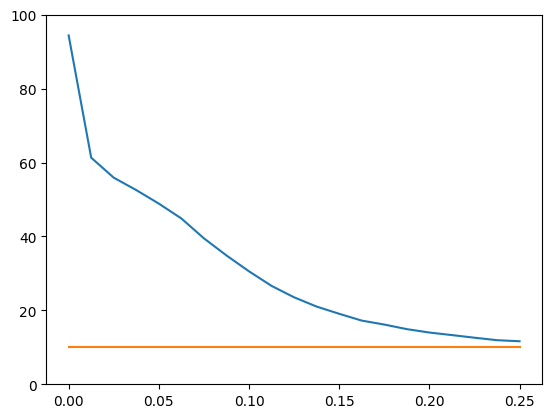

In [22]:
import matplotlib.pyplot as plt

plt.plot(all_eps, adv_acc)
#plt.plot(all_eps, adv_acc_cnn)
plt.plot(all_eps, len(all_eps)*[10])
plt.ylim(0, 100)

In [20]:
avd_acc = np.array(adv_acc)
adv_top5 = np.array(adv_top5)

In [21]:
np.save('adv_acc_mlp_cifar10', adv_acc)
np.save('adv_top5_mlp_cifar10', adv_top5)

## Marcel's part
Run cells 1, 2, 5 & 6 before this and change data_path below

In [26]:
for model in ['mlp', 'cnn']:
    for dataset in ['cifar10', 'cifar100']:
        is_mlp = model == 'mlp'

        adv_acc = []
        adv_top5 = []
        data_loader, model = get_data_and_model(dataset=dataset, model=model, data_path='/scratch/ffcv/')
        all_eps = np.arange(0,0.26,0.0125)

        for eps in tqdm(all_eps, desc="Evaluating"):
            test_adv_acc, test_adv_top5 = test_adversarial(model, dataset, data_loader, eps, 'pgd', is_mlp = is_mlp)

            adv_acc.append(test_adv_acc)
            adv_top5.append(test_adv_top5)

        acc_fname = 'pgd_acc_' + model + '_' + dataset
        top5_fname = 'pgd_top5_' + model + '_' + dataset
        
        np.save(acc_fname, np.array(adv_acc))
        np.save(top5_fname, np.array(adv_top5))

Weights already downloaded
Load_state output <All keys matched successfully>
Loading /scratch/ffcv/cifar10/val_32.beton


Evaluating:   0%|          | 0/21 [01:15<?, ?it/s]


KeyboardInterrupt: 